# PINNs Warm-Up

In [1]:
# Imports
from fenics import *
import torch
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

## PDE

The problem at hand is:

\begin{equation}
-\kappa \Delta u + \beta \cdot \nabla u = f \quad x\in\Omega :=(0,1)^2 \\
u|_{\partial \Omega}=0
\end{equation}

With the following definitions: 

\begin{equation}
\kappa = 10^{-2}, \quad \beta=[1/2, 1]/\sqrt{1.25}, \quad f(x,y)=\begin{cases} +1 & y\geq 2x, \\ -1 & y<2x\end{cases}
\end{equation}



## Part 1 - Fenics

In [2]:
# Constants
kappa = 10e-2
beta1 = 1/2/(1.25)**0.5
beta2 = 1/(1.25)**0.5

In [18]:
# Fix Finite elements
mesh = UnitSquareMesh(1000, 1000)
V = FunctionSpace(mesh, "P", 1)

u_D = Constant(0.0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

u = TrialFunction(V)
v = TestFunction(V)

f = Expression("x[1] >= 2*x[0] ? 1 : -1", degree=1)

beta = Constant((beta1, beta2))

a = (Constant(kappa) * inner(nabla_grad(u), nabla_grad(v)) + inner(beta, nabla_grad(u)) * v) * dx

L = f*v*dx

u = Function(V)
solve(a == L, u, bc)


Calling FFC just-in-time (JIT) compiler, this may take some time.


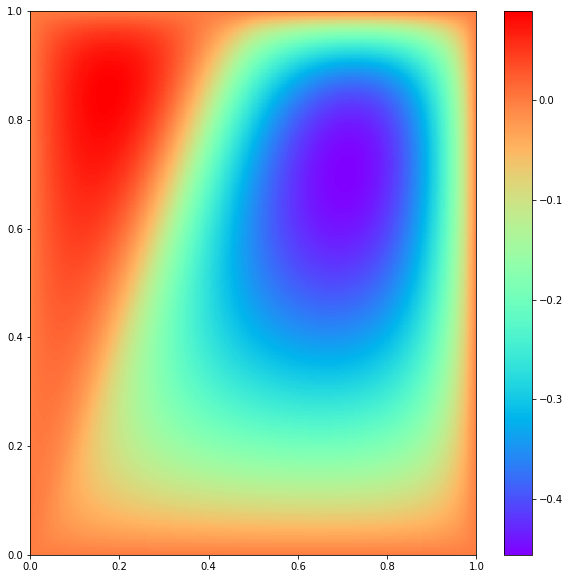

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x = np.linspace(0,1, 400)
xx, yy = np.meshgrid(x, x)

zz = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        zz[i,j] = u(xx[i, j], yy[i, j])
        
h = ax.pcolormesh(x, x, zz, shading="auto", cmap="rainbow")
fig.colorbar(h)      
plt.show()

## Part 2 - PINNs

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"On device: {device}")
device = torch.device("cpu")

On device: cpu


### Optimization problem
$\mathcal{NN}:(0,1)^2\rightarrow \mathbb{R}$, so in fact: $u=\mathcal{NN}$. Then optimize:
\begin{equation}
\min_{u} [ ||-\kappa \Delta u + \beta \cdot \nabla u - f||^2 +||u|_{\partial \Omega}||^2 ]
\end{equation}

Loss: 0.0036: 100%|██████████| 10000/10000 [02:32<00:00, 65.70it/s]


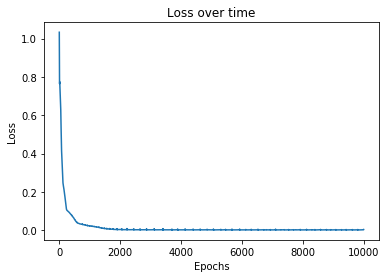

In [5]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.depth = len(layers) - 1
        
        self.activation = torch.nn.Tanh
        
        l = []
        
        for i in range(self.depth - 1):
            l.append(
                (f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1])))
            l.append(
                (f"activation_{i}", self.activation()))
        l.append(
            (f"layer_{self.depth-1}", torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(l)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, x):
        out = self.layers(x)
        return out


class PINN:
    def __init__(self, layers):
        self.dnn = DNN(layers).to(device)
        self.optimizer = torch.optim.Adam(self.dnn.parameters())
    
    def generate_train_data_grid(self, num):
        # Boundary
        x = torch.linspace(0, 1, num)
        bc1 = torch.vstack((torch.zeros(num), x)).T
        bc2 = torch.vstack((torch.ones(num), x)).T
        bc3 = torch.vstack((x, torch.zeros(num))).T
        bc4 = torch.vstack((x, torch.ones(num))).T
        self.boundary = torch.vstack((bc1, bc2, bc3, bc4)).to(device)
        
        # Interior
        xx, yy = torch.meshgrid(x[1:-1], x[1:-1])
        self.interior = torch.vstack((xx.flatten(), yy.flatten())).T.to(device)
        
    def generate_train_data_random_uniform(self, num):
        eps = 1e-6
        self.interior = torch.rand((num*num, 2)).to(device)
        
        bc1 = torch.vstack((torch.rand(num), torch.zeros(num))).T
        bc2 = torch.vstack((torch.rand(num), torch.ones(num))).T
        bc3 = torch.vstack((torch.zeros(num), torch.rand(num))).T
        bc4 = torch.vstack((torch.ones(num), torch.rand(num))).T
        self.boundary = torch.vstack((bc1, bc2, bc3, bc4)).to(device)
        
    
    def u(self, x):
        return self.dnn(x)
    
    def f(self, x):
        return torch.heaviside(x[:, 1]-2*x[:, 0], torch.tensor(0.0)) - torch.heaviside(2*x[:, 0]-x[:, 1], torch.tensor(0.0))
    
    def loss(self):
        # Interior
        interior = self.interior.clone()
        interior.requires_grad = True
        
        u = self.u(interior)
        
        
        u_xy = torch.autograd.grad(u, interior, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xxyy = torch.autograd.grad(u_xy, interior, grad_outputs=torch.ones_like(u_xy), retain_graph=True, create_graph=True)[0]
        
        interior_loss = -kappa * (u_xxyy[:, 0] + u_xxyy[:, 1]) + beta1*u_xy[:, 0] + beta2*u_xy[:, 1] - self.f(interior)
        
        # Boundary
        boundary = self.boundary.clone()
        boundary.requires_grad = True
        
        u = self.u(boundary)
        boundary_loss = u
        
        loss = torch.mean(interior_loss**2) + torch.mean(boundary_loss**2)
        
        return loss
    
    def train(self, epochs, num, distr="grid"):
        if distr == "grid":
            self.generate_train_data_grid(num)
        else:
            self.generate_train_data_random_uniform(num)
        
        losses = np.zeros(epochs)
        
        bar = tqdm(range(epochs), desc="Loss: ~")
        
        for i in bar:
            self.optimizer.zero_grad()
            loss = self.loss()
            loss.backward()
            self.optimizer.step()
            losses[i] = loss.detach().cpu().numpy()
            bar.set_description(f"Loss: {losses[i]:.4f}")
        return losses
    
    def plot_solution(self):
        model.dnn.cpu()
        x = torch.linspace(0, 1, 400)
        xx, yy = torch.meshgrid(x, x)
        data = torch.stack((xx, yy), dim=2).view(-1, 2)
        u = model.dnn(data).detach()
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        
        h = ax.pcolormesh(x, x, u.view(400, 400).T, shading="auto", cmap="rainbow")
        fig.colorbar(h)
        ax.plot(self.interior[:, 0], self.interior[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)
        ax.plot(self.boundary[:, 0], self.boundary[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)        
        plt.show()


model = PINN([2, 50, 50, 50, 1])
losses = model.train(10000, 45)

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.show()


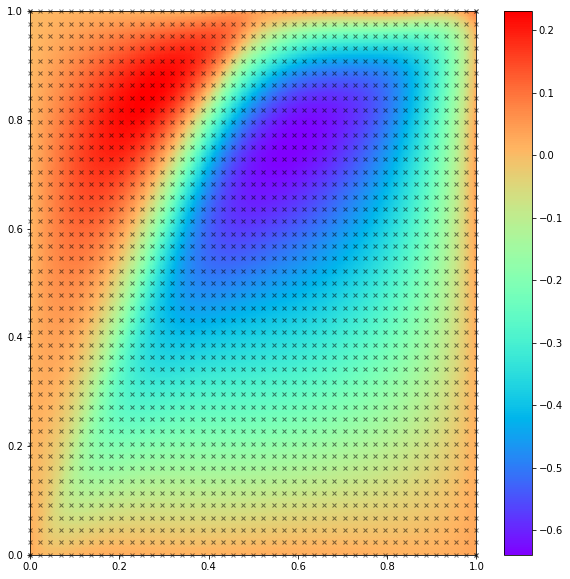

In [6]:
model.plot_solution()